<a href="https://colab.research.google.com/github/HOOd-00/CPE324-Task4_CNN/blob/main/Swin_MLTask4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Dependencies

## LIB

In [1]:
!pip install transformers --quiet

In [2]:
import os
from google.colab import drive

import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import layers, Model
from keras.metrics import F1Score
from keras.callbacks import ModelCheckpoint, EarlyStopping

from transformers import TFSwinModel

from sklearn.utils import class_weight
import albumentations as A

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Config

In [3]:
# ตัวแปร AUTOTUNE เพื่อให้ tf.data ทำงานเร็วขึ้น
AUTOTUNE = tf.data.AUTOTUNE

### 2. CONFIGURATION (Control Panel) ###
# --- Paths ---
DRIVE_PATH = '/content/drive/MyDrive/KMUTT/ML_Task4'
LOCAL_PATH = '/content/data'
TRAIN_IMG_DIR = os.path.join(LOCAL_PATH, 'train')
VALID_IMG_DIR = os.path.join(LOCAL_PATH, 'val')
TEST_IMG_DIR  = os.path.join(LOCAL_PATH, 'test')

TRAIN_CSV = os.path.join(LOCAL_PATH, 'train.csv')
VALID_CSV = os.path.join(LOCAL_PATH, 'val.csv')
TEST_CSV  = os.path.join(LOCAL_PATH, 'test.csv')

# --- Model & Training Params ---
IMG_SIZE   = 224 # ขนาดภาพที่ Swin ต้องการ
BATCH_SIZE = 32
EPOCHS     = 15
LR         = 1e-5 # Learning rate ต่ำๆ สำหรับ Fine-tuning
MODEL_NAME = "microsoft/swin-base-patch4-window7-224"

# --- Data Class ---
data_class = {
    0 : "7-11K",
    1 : "fiveN",
    2 : "freefried",
    3 : "pube",
    4 : "roblock"
}

## Load Zip Dataset

In [4]:
# --- Mount Drive ---
drive.mount('/content/drive')

# --- Create Local Dirs ---
os.makedirs(LOCAL_PATH, exist_ok=True)

# --- Copy & Unzip Data (รันแค่ครั้งเดียว) ---
print("Copying data from Drive...")
!cp "{DRIVE_PATH}/train.zip" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/val.zip" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/test.zip"  "{LOCAL_PATH}"

!cp "{DRIVE_PATH}/train.csv" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/val.csv" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/test.csv" "{LOCAL_PATH}"

print("Unzipping data...")
!unzip -q "{LOCAL_PATH}/train.zip" -d "{LOCAL_PATH}/"
!unzip -q "{LOCAL_PATH}/val.zip" -d "{LOCAL_PATH}/"
!unzip -q "{LOCAL_PATH}/test.zip"  -d "{LOCAL_PATH}/"

print("Data is ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying data from Drive...
Unzipping data...
Data is ready.


# 2. EDA

Train samples: 31546
Valid samples: 24772


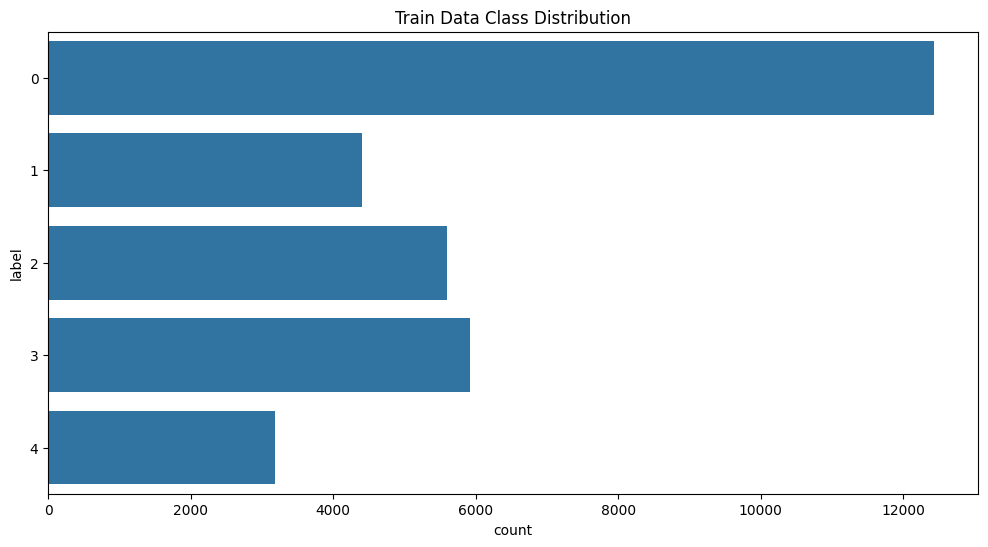

Total Classes: 5


In [5]:
# --- Load CSVs ---
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)
df_test  = pd.read_csv(TEST_CSV)

print(f"Train samples: {len(df_train)}")
print(f"Valid samples: {len(df_valid)}")

# --- EDA: Class Distribution ---
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='label')
plt.title('Train Data Class Distribution')
plt.show()

# เก็บจำนวน Class ไว้ใช้ตอนสร้างโมเดล
NUM_CLASSES = len(df_train['label'].unique())
print(f"Total Classes: {NUM_CLASSES}")

In [6]:
# จัดการกับ Imbalance โดยใช้ Class Weights
# ใช้ y_train ที่เป็นตัวเลข (label_id)
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)

# Keras ต้องการ class_weight ในรูป Dictionary (map จาก ID ไปยัง weight)
class_weights_dict = dict(enumerate(class_weights_array))

print("Class Weights ที่จะใช้:")
print(class_weights_dict)

Class Weights ที่จะใช้:
{0: np.float64(0.5076192774961783), 1: np.float64(1.4316314953483096), 2: np.float64(1.1274481772694782), 3: np.float64(1.0646641916976038), 4: np.float64(1.9790464240903387)}


# 3. Preprocessing

In [7]:
# 1. Resize
# ใช้ pipeline เดียวกันนี้สำหรับ train, valid, และ test
def get_transforms():
    return A.Compose([
        A.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    ], p=1.0)

# 2. Wrapper function for tf.py_function
def apply_albumentations(image, label):
    # Create transform inside the function called by tf.py_function
    transform = get_transforms()
    image_np = image.numpy()
    processed = transform(image=image_np)
    image_proc = processed['image']
    return image_proc, label

# 3. Wrapper for tf.data
def proc_fn(image, label):
    image_proc, label = tf.py_function(
        func=apply_albumentations,
        inp=[image, label], # Only pass Tensors here
        Tout=[tf.uint8, tf.int32] # Input เป็น uint8 (0-255)
    )
    return image_proc, label

# 4. Data Pipeline

In [8]:
# --- 1. Base function: Load image ---
# ฟังก์ชันนี้จะถูก map เข้าไปใน tf.data
def load_image_and_label(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

# --- 2. Normalization function ---
# (Swin Transformer ใน Keras ไม่ต้องการ /255.0 แต่จะถูกจัดการโดย Layer ภายใน)
# เราจะใช้ Preprocessing Layer ในโมเดลแทน
def set_shape_fn(image, label):
    # py_function มักจะลืม shape, เราต้องกำหนดกลับ
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label.set_shape([])
    return image, label

# --- 3. Function to create the final Dataset ---
def create_tf_dataset(df, img_dir, is_train=True):
    # สร้าง Path เต็ม
    full_paths = [os.path.join(img_dir, fname) for fname in df['file_name']]
    labels = df['label']

    ds = tf.data.Dataset.from_tensor_slices((full_paths, labels))

    if is_train:
        ds = ds.shuffle(buffer_size=len(df))

    # 1. โหลดภาพ
    ds = ds.map(load_image_and_label, num_parallel_calls=AUTOTUNE)

    # 2. Pre-process (Resize)
    # เราใช้ proc_fn ทั้ง train และ valid
    ds = ds.map(proc_fn, num_parallel_calls=AUTOTUNE)

    # 3. ตั้งค่า Shape
    ds = ds.map(set_shape_fn, num_parallel_calls=AUTOTUNE)

    # 4. Batch และ Prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# --- Create Datasets ---
train_ds = create_tf_dataset(df_train, TRAIN_IMG_DIR, is_train=True)
valid_ds = create_tf_dataset(df_valid, VALID_IMG_DIR, is_train=False)

print("tf.data pipelines created (using Resize only).")

tf.data pipelines created (using Resize only).


# 5. Model Building

In [25]:
# ค่ามาตรฐานของ ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
IMAGENET_VAR  = [s**2 for s in IMAGENET_STD]


# ====== MODEL DEFINITION ======
# ✅ 1. ห่อ Backbone ด้วย Layer เพื่อให้ Keras มองเห็น weights
class SwinBackboneLayer(layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.model = TFSwinModel.from_pretrained(model_name, from_pt=True)

    def call(self, x, training=False):
        outputs = self.model(x, training=training)
        return outputs.last_hidden_state


# ✅ 2. โมเดลหลัก
class SwinGameClassifier(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes

        self.rescaling = layers.Rescaling(1./255)
        self.normalization = layers.Lambda(
            lambda x: (x - tf.constant(IMAGENET_MEAN)) / tf.constant(IMAGENET_STD)
        )
        self.permute = layers.Permute((3, 1, 2))

        # 🔥 ใช้ layer ที่ห่อ backbone ไว้
        self.backbone = SwinBackboneLayer(MODEL_NAME)
        self.backbone.trainable = True

        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(0.3)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.rescaling(inputs)
        x = self.normalization(x)
        x = self.permute(x)
        x = self.backbone(x, training=training)
        x = self.pooling(x)
        x = self.dropout(x, training=training)
        return self.classifier(x)


# ✅ 3. ทดสอบ Build
model = SwinGameClassifier(num_classes=NUM_CLASSES)
dummy = tf.zeros((1, IMG_SIZE, IMG_SIZE, 3))
_ = model(dummy)  # force build

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFSwinModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSwinModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSwinModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinModel for predictions without further training.


Model: "swin_game_classifier_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (1, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (1, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_16 (Permute)            │ (1, 3, 224, 224)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_backbone_layer             │ ?                      │             0 │
│ (SwinBackboneLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (1, 5)                 │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,125 (20.02 KB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 0 (0.00 B)